In [75]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

from copy import deepcopy

!pip install nlopt
import nlopt

# Models

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [76]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [77]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Dataset

In [78]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Labels

In [79]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

In [80]:
data = pd.read_csv('experiments_data_student_5_local_min_only.csv', float_precision='round_trip')

len(data)

426

In [81]:
sample_point = data.loc[20]
sample_point['loss']

7.340985286608199e-05

# Helper for extracting the weights from one data point.

In [82]:
def extract_weights(data_point):
  incoming_weights_x = []
  incoming_weights_y = []
  outgoing_weights = []

  for i in range(0, int(data_point['student size'])):
    neuron_traj_x = np.fromstring(data_point['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_point['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    incoming_weights_x.append(neuron_traj_x[-1])
    incoming_weights_y.append(neuron_traj_y[-1])
    neuron_traj_out = np.fromstring(data_point['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    outgoing_weights.append(neuron_traj_out[-1])

  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [83]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)

[-1.2775172768176173, -0.7305619998746957, -0.902261813535612, -1.2970533572266183, 0.19422289278673627]
[1.0288394419098346, 1.4871552140321722, -0.585449488585722, 1.0423031847131665, -0.05411534809447417]
[-10.878693547030105, 0.07176512294046739, -0.45498075571767316, 10.485803314933506, 0.7761178150337397]


In [84]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

# Plotting of the neuron point

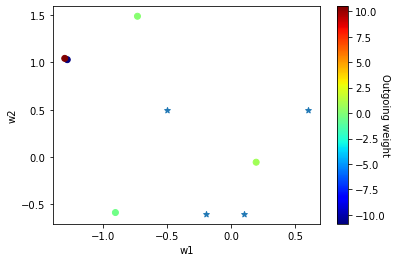

In [85]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar().set_label('Outgoing weight',rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

# JAX helpers for finding an escape route

## Constructing the network in JAX

In [86]:
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 

jnp_inputs = jnp.array(construct_dataset(), dtype=jnp.float64)
jnp_labels = jnp.array(teacher_model(dataset).detach(), dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
w_out = jnp.array(outgoing_weights, dtype=jnp.float64)

## Loss in JAX

Loss of the network computed in JAX.

In [87]:
def loss(w):
  network_size = int(len(w) / 3)
  w_in = w[0 : 2 * network_size].reshape(network_size, D_in)
  w_out = w[2 * network_size : ].reshape(1, network_size)
  preds = jnp.transpose(predict(w_in, w_out))
  return jnp.mean(jnp.square(preds - jnp_labels))
print(loss(jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student))))

7.34098528660821e-05


## Hessian in JAX

In [88]:
from jax import jacfwd, jacrev
from jax import grad as jax_grad
import jax

def hessian(f):
  return jacfwd(jacrev(f))

H = hessian(loss)(jnp.append(w_in.reshape(D_in * H_student), w_out.reshape(H_student)))
H = (H + H.T) / 2

## Eigenvalues in JAX

In [89]:
evals, evectors = jnp.linalg.eigh(H)
evals.sort()

print(evals[:3])
smallest_evector = evectors[:, jnp.argmin(evals)]
print(smallest_evector)

[1.0769084856041805e-11 4.8867150691374053e-06 2.7672684188909523e-05]
[-6.3440338692776301e-04  4.3687266349880938e-04 -7.5853246525467099e-07
 -1.5877209914003354e-06  4.4140111609873635e-07  2.6440007531088599e-07
  6.5930451714313364e-04 -4.5473136859610773e-04  1.4671954859855007e-07
 -4.0686026372262618e-07 -7.0710607304234319e-01  1.0872426486259374e-07
 -3.3375639810469296e-07  7.0710661620042758e-01 -3.1782346122772410e-07]


## Perturbation (based on JAX evectors) in the dir of smallest evector

In [90]:
old_loss = loss(jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student)))

perturb_lower_bound = -8.0
perturb_upper_bound = 8.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []
perturb_grads = []

weights = jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  perturb_grads.append(jnp.linalg.norm(jax_grad(loss)(new_weights)))
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eigh(H)

  perturb_evals.append(min(evals))
  perturb_losses.append(loss(new_weights))

## Plot the result of perturbation

Text(0, 0.5, 'gradient norm')

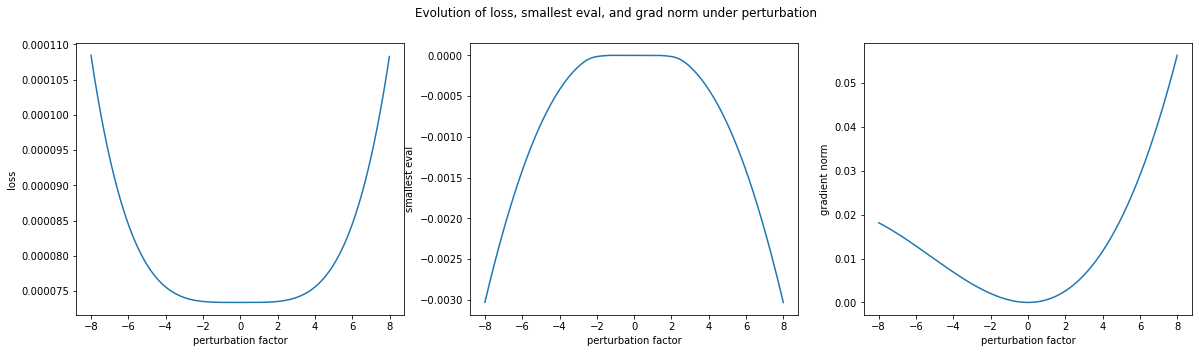

In [91]:
fig_escape, axs = plt.subplots(1, 3)
fig_escape.set_size_inches(20, 5)
fig_escape.suptitle('Evolution of loss, smallest eval, and grad norm under perturbation')

axs[0].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
axs[0].ticklabel_format(useOffset=False)
axs[0].set_xlabel('perturbation factor')
axs[0].set_ylabel('loss')

axs[1].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
axs[1].set_xlabel('perturbation factor')
axs[1].set_ylabel('smallest eval')

axs[2].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
axs[2].set_xlabel('perturbation factor')
axs[2].set_ylabel('gradient norm')

# Perturbation in the direction of the smallest evectors

In [92]:
from collections import deque

def run_perturbation_algo(start_weights,
                          perturb_losses,
                          eps = 1e-1):
  q = deque()
  q.append((start_weights, 0))

  while len(q) > 0:
    current_weights, current_dist = q.popleft()
    perturb_losses.append(loss(current_weights))

    H = hessian(loss)(current_weights)
    H = (H + H.T) / 2
    evals, evectors = jnp.linalg.eigh(H)

    for idx, eval in enumerate(evals):
      if eval >= 1e-10:
        continue
      
      current_evector = evectors[:, idx]

      new_weights = current_weights + eps * current_evector
      new_dist = round(np.linalg.norm(new_weights - start_weights) / eps)
        
      if jnp.linalg.norm(jax_grad(loss)(new_weights)) <= 1e-9 and \
         new_dist > current_dist:
        print(round(np.linalg.norm(new_weights - start_weights) / eps))
        q.append((new_weights, new_dist))

      new_weights = current_weights - eps * current_evector
      new_dist = round(np.linalg.norm(new_weights - start_weights) / eps)

      if jnp.linalg.norm(jax_grad(loss)(new_weights)) <= 1e-9 and \
         new_dist > current_dist:
        print(round(np.linalg.norm(new_weights - start_weights) / eps))
        q.append((new_weights, new_dist))

perturb_losses = []
eps = 1e-1
while len(perturb_losses) < 50 and eps >= 1e-12:
  perturb_losses = []
  print('new eps:', eps)
  run_perturbation_algo(weights, perturb_losses, eps)
  eps /= 1.2
  if eps < 1e-12:
    break

print(len(perturb_losses), min(perturb_losses))

new eps: 0.1
new eps: 0.08333333333333334
new eps: 0.06944444444444446
new eps: 0.057870370370370385
new eps: 0.04822530864197532
new eps: 0.0401877572016461
new eps: 0.03348979766803842
new eps: 0.02790816472336535
new eps: 0.023256803936137792
new eps: 0.019380669946781493
new eps: 0.016150558288984578
new eps: 0.013458798574153816
new eps: 0.011215665478461513
new eps: 0.009346387898717928
new eps: 0.00778865658226494
new eps: 0.00649054715188745
new eps: 0.005408789293239542
new eps: 0.004507324411032952
new eps: 0.0037561036758607933
new eps: 0.003130086396550661
new eps: 0.0026084053304588845
new eps: 0.0021736711087157372
new eps: 0.0018113925905964478
new eps: 0.0015094938254970399
new eps: 0.0012579115212475332
1
1
new eps: 0.001048259601039611
1
1
new eps: 0.0008735496675330093
1
1
2
2
new eps: 0.0007279580562775077
1
1
2
2
3
3
new eps: 0.0006066317135645898
1
1
2
2
3
3
4
4
new eps: 0.0005055264279704916
1
1
2
2
3
3
4
4
5
5
6
6
new eps: 0.000421272023308743
1
1
2
2
3
3
4
4
5


# Extract the average of the 2 neurons close to each other.

## Find the two closest neurons

In [93]:
min_dist = np.inf
idx_neuron1 = None
idx_neuron2 = None

for i in range(H_student):
  current_neuron = np.array([incoming_weights_x[i], incoming_weights_y[i]])
  for j in range(i + 1, H_student):
    potential_closest_neuron = np.array([incoming_weights_x[j], incoming_weights_y[j]])
    if min_dist > np.linalg.norm(current_neuron - potential_closest_neuron):
      min_dist = np.linalg.norm(current_neuron - potential_closest_neuron)
      idx_neuron1 = i
      idx_neuron2 = j

## Extract the average neuron from the previous 2 ones.

In [94]:
new_incoming_weights_x = [(incoming_weights_x[idx_neuron1] + incoming_weights_x[idx_neuron2]) / 2.0]
new_incoming_weights_y = [(incoming_weights_y[idx_neuron1] + incoming_weights_y[idx_neuron2]) / 2.0]
new_outgoing_weights = [(outgoing_weights[idx_neuron1] + outgoing_weights[idx_neuron2])]

for i in range(H_student):
  if i == idx_neuron1 or i == idx_neuron2:
    continue
  new_incoming_weights_x.append(incoming_weights_x[i])
  new_incoming_weights_y.append(incoming_weights_y[i])
  new_outgoing_weights.append(outgoing_weights[i])

## Replotting of the lower-size neuron point

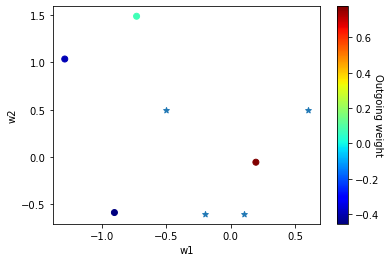

In [95]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(new_incoming_weights_x,
            new_incoming_weights_y,
            c = new_outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar().set_label('Outgoing weight',rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

# Train the model from this point

## Create new NN of size 4 after reduction of 1 neuron

In [96]:
w_in = torch.DoubleTensor([[new_incoming_weights_x[0], new_incoming_weights_y[0]],
                           [new_incoming_weights_x[1], new_incoming_weights_y[1]],
                           [new_incoming_weights_x[2], new_incoming_weights_y[2]],
                           [new_incoming_weights_x[3], new_incoming_weights_y[3]]])
w_out = torch.DoubleTensor([new_outgoing_weights])
dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in, w_out)

## Define loss objective for second order opt.

In [97]:
def loss_obj(weights, grad):
  loss_val = loss(weights)
  if grad.size > 0:
    grad[:] = np.array(jax_grad(loss)(weights), dtype=np.float64)
  return np.float64(loss_val)

## End-to-end training helper method

In [98]:
def train(model, x, y_labels, N = 10, Ninner = 10 ** 3, Nstart = 10,
          collect_history = True):
  optimizer = torch.optim.Adam(model.parameters())
  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                  deepcopy(model.linear2.weight.data.detach().numpy())))
  for i in range(1, N + 1):
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart  : j]))
        if collect_history:
          trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                        deepcopy(model.linear2.weight.data.detach().numpy())))
    loss_vals.append(np.mean(loss_tmp))
    if collect_history:
      trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                    deepcopy(model.linear2.weight.data.detach().numpy())))
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    
    # Adjust the learning rate.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr / (1 + i)
    
    # stopping criterion
    if i == N:
        num_neurons = model.linear1.weight.shape[0]
        weights = np.append(trace[-1][0].reshape(num_neurons * 2), trace[-1][1][0].reshape(num_neurons))
        # opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
        # opt.set_lower_bounds([w - 10 for w in weights])
        # opt.set_upper_bounds([w + 10 for w in weights])
        # opt.set_min_objective(loss_obj)
        # opt.set_maxtime(5)
        # final_weights = opt.optimize(weights)
        # return loss_vals, trace, final_weights
        return loss_vals, trace, weights

def train_second_order(model):
    num_neurons = model.linear1.weight.shape[0]
    weights = np.append(model.linear1.weight.data.detach().numpy().reshape(num_neurons * 2),
                        model.linear2.weight.data.detach().numpy().reshape(num_neurons))
    lower_bound = weights - 0.5
    upper_bound = weights + 0.5
    opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
    opt.set_lower_bounds(lower_bound)
    opt.set_upper_bounds(upper_bound)
    opt.set_min_objective(loss_obj)
    opt.set_maxtime(5)
    opt.set_xtol_rel(1e-10)
    opt.set_initial_step(1e-32)
    final_weights = opt.optimize(weights)
    return final_weights

def perturbed_train_second_order(model):
    num_neurons = model.linear1.weight.shape[0]
    weights = np.append(model.linear1.weight.data.detach().numpy().reshape(num_neurons * 2),
                        model.linear2.weight.data.detach().numpy().reshape(num_neurons))

    mu, sigma = 0, 0.5 # mean and standard deviation of the sample Gaussian
    num_perturbations = 1
    
    perturbed_losses = []
    perturbed_grads = []
    perturbed_final_weights = []
    for i in range(num_perturbations):
        perturbation = np.random.normal(mu, sigma, len(weights))
        perturbed_weights = weights + perturbation
        lower_bound = perturbed_weights - 10
        upper_bound = perturbed_weights + 10
        opt = nlopt.opt(nlopt.LD_SLSQP, len(perturbed_weights))
        opt.set_lower_bounds(lower_bound)
        opt.set_upper_bounds(upper_bound)
        opt.set_min_objective(loss_obj)
        opt.set_maxtime(1)
        opt.set_xtol_rel(1e-10)
        opt.set_initial_step(1e-32)
        final_weights = opt.optimize(perturbed_weights)
        perturbed_losses.append(loss(final_weights))
        perturbed_grads.append(jnp.linalg.norm(jax_grad(loss)(final_weights)))
        perturbed_final_weights.append(final_weights)
    return perturbed_losses, perturbed_grads, perturbed_final_weights

In [99]:
np.set_printoptions(precision=32)
# loss_vals, trace, final_weights = train(dummy_model, dataset, y_labels)
final_weights = train_second_order(dummy_model)
print(loss(final_weights))
print(jnp.linalg.norm(jax_grad(loss)(final_weights)))

7.969688343304275e-05
6.565029923793567e-07


In [100]:
perturbed_losses, perturbed_grads, perturbed_final_weights = perturbed_train_second_order(dummy_model)

In [101]:
perturbed_grads = np.array(perturbed_grads)
perturbed_losses = np.array(perturbed_losses)
perturbed_final_weights = np.array(perturbed_final_weights)
# perturbed_losses = perturbed_losses[perturbed_losses >= 1e-6]

Text(0, 0.5, 'Loss')

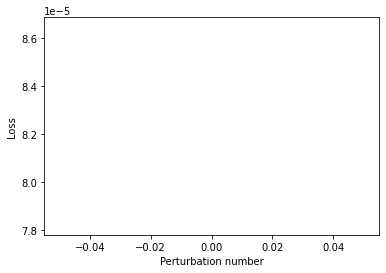

In [102]:
plt.plot(np.arange(0, len(perturbed_losses)), perturbed_losses)
plt.xlabel('Perturbation number')
plt.ylabel('Loss')

In [103]:
w_in_torch_format = torch.DoubleTensor(final_weights[0 : H_teacher * 2].reshape(H_teacher, 2))
w_out_torch_format = torch.DoubleTensor([final_weights[H_teacher * 2 :].reshape(H_teacher)])

# dummy_model = DummyNetwork(D_in, H_teacher, D_out,
#                            torch.DoubleTensor(trace[-1][0]),
#                            torch.DoubleTensor(trace[-1][1]))
# loss_val = nn.MSELoss()(dummy_model(dataset), y_labels)
# print('loss before second order opt.: ',loss_val.item())
# loss_grad = torch.autograd.grad(loss_val, dummy_model.parameters(), create_graph=True)
# gradients = loss_grad[0].reshape(H_teacher * 2).detach().numpy()
# gradients = np.append(gradients, loss_grad[1][0].detach().numpy())
# print('grad norm before second order opt.: ', np.linalg.norm(gradients))

dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in_torch_format, w_out_torch_format)
loss_val = nn.MSELoss()(dummy_model(dataset), y_labels)
print('loss after second order opt.: ',loss_val.item())
loss_grad = torch.autograd.grad(loss_val, dummy_model.parameters(), create_graph=True)
gradients = loss_grad[0].reshape(H_teacher * 2).detach().numpy()
gradients = np.append(gradients, loss_grad[1][0].detach().numpy())
print('grad norm after second order opt.: ', np.linalg.norm(gradients))

loss after second order opt.:  7.969688343304276e-05
grad norm after second order opt.:  6.565029923787715e-07


# Replot the neuron points after training

In [104]:
total_outgoing_weights = np.concatenate([outgoing_weights, w_out_torch_format[0]], axis=0)
min_outgoing_weight, max_outgoing_weight = total_outgoing_weights.min(), total_outgoing_weights.max()

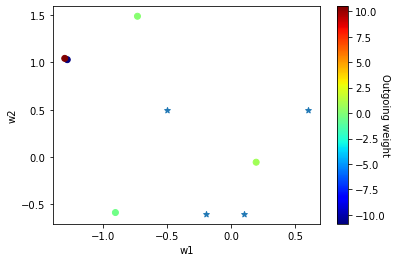

In [105]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

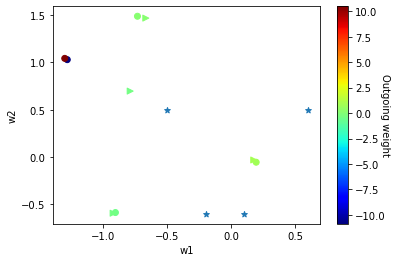

In [106]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

# plt.scatter(trace[-1][0][:, 0],
#             trace[-1][0][:, 1],
#             c = trace[-1][1][0],
#             cmap = matplotlib.cm.jet,
#             marker="+")

plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format[0],
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

In [107]:
local_min = np.array([incoming_weights_x[0], incoming_weights_y[0],
             incoming_weights_x[1], incoming_weights_y[1],
             incoming_weights_x[2], incoming_weights_y[2],
             incoming_weights_x[3], incoming_weights_y[3],
             incoming_weights_x[4], incoming_weights_y[4],
             outgoing_weights[0], outgoing_weights[1], outgoing_weights[2],
             outgoing_weights[3], outgoing_weights[4]])
print(local_min)

[ -1.2775172768176173    1.0288394419098346   -0.7305619998746957
   1.4871552140321722   -0.902261813535612    -0.585449488585722
  -1.2970533572266183    1.0423031847131665    0.19422289278673627
  -0.05411534809447417 -10.878693547030105     0.07176512294046739
  -0.45498075571767316  10.485803314933506     0.7761178150337397 ]


# Find the SI saddle line and the optimal \mu

In [108]:
def construct_si_saddle(final_weights, mu):
    num_neurons = int(len(final_weights) / 3)
    w_in_torch_format = torch.DoubleTensor(final_weights[0 : num_neurons * 2].reshape(num_neurons, 2))
    w_out_torch_format = torch.DoubleTensor([final_weights[num_neurons * 2 :].reshape(num_neurons)])

    si_saddle = np.array([])
    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1 or i == idx_neuron2:
        si_saddle = np.append(si_saddle, w_in_torch_format[0][0].item())
        si_saddle = np.append(si_saddle, w_in_torch_format[0][1].item())
        continue
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][0].item())
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][1].item())
      teacher_idx += 1

    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1:
        si_saddle = np.append(si_saddle,
                              mu * w_out_torch_format[0][0].item())
        continue
      if i == idx_neuron2:
        si_saddle = np.append(si_saddle,
                              (1 - mu) * w_out_torch_format[0][0].item())
        continue
      si_saddle = np.append(si_saddle,
                            w_out_torch_format[0][teacher_idx].item())
      teacher_idx += 1

    return si_saddle

In [109]:
def find_saddle_line(final_weights):
    saddle_smallest_u = construct_si_saddle(final_weights, -1)
    saddle_largest_u = construct_si_saddle(final_weights, 2)
    
    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    optimal_mu = closest_saddle[2 * H_student + idx_neuron1] / w_out_torch_format[0][0].item()
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, optimal_mu, directional_vector

In [110]:
closest_saddle, optimal_mu, directional_vector = find_saddle_line(final_weights)
print('Optimal mu:', optimal_mu)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Optimal mu: 24.707089448483906
Distance to local min: 0.8591064361832984


0.8937576690796551


Text(0, 0.5, 'Distance to local min')

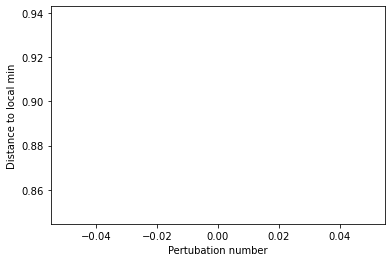

In [111]:
perturbed_distances_to_local_min = []

for perturbed_final_weights_sample in perturbed_final_weights:
    perturbed_closest_saddle, perturbed_optimal_mu, perturbed_directional_vector = find_saddle_line(perturbed_final_weights_sample)
    new_dist_min_saddle = np.linalg.norm(local_min - perturbed_closest_saddle)
    if new_dist_min_saddle < dist_min_saddle:
        dist_min_saddle = new_dist_min_saddle
        closest_saddle = perturbed_closest_saddle
        optimal_mu = perturbed_optimal_mu
        directional_vector = perturbed_directional_vector
    perturbed_distances_to_local_min.append(new_dist_min_saddle)
print(min(perturbed_distances_to_local_min))
plt.plot(np.arange(0, len(perturbed_distances_to_local_min)), perturbed_distances_to_local_min)
plt.xlabel('Pertubation number')
plt.ylabel('Distance to local min')

Text(0, 0.5, 'Distance (L2) to local min')

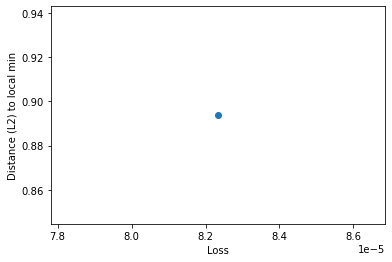

In [112]:
plt.scatter(perturbed_losses, perturbed_distances_to_local_min)
plt.xlabel('Loss')
# plt.xscale('log')
plt.ylabel('Distance (L2) to local min')

# Eigenspectrum of the closest SI saddle

[-6.5368301962316684e-05  1.4702589269187720e-11  6.3597643025279776e-06
  1.1157888918289352e-04  1.9731047935686751e-04  3.2645618504396196e-04
  8.1626867931011628e-04  7.7130389459876929e-03  1.2506967104190593e-02
  1.7837452588537486e-02  2.0746411883657034e-01  5.3126048406274973e-01
  2.6587443220031028e+00  9.5538844119312802e+00  1.2300095904641485e+02]


Text(0, 0.5, 'Eigenvalue')

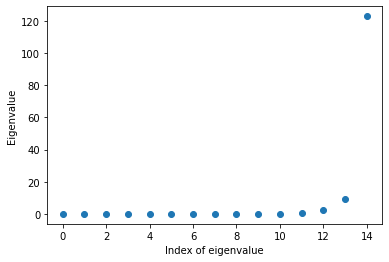

In [113]:
H = hessian(loss)(closest_saddle)
H = (H + H.T) / 2
evals, _ = jnp.linalg.eigh(H)
print(evals)
plt.scatter(np.arange(len(evals)), evals)
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue')

# Compute loss across the 1D line between local min and closest saddle

In [114]:
def loss_from_flattened_neuron_point(neuron_point):
  neuron_point_w_in = torch.DoubleTensor(neuron_point[0 : 2 * H_student].reshape(H_student, 2))
  neuron_point_w_out = torch.DoubleTensor([neuron_point[2 * H_student : ].reshape(H_student)])

  dummy_model = DummyNetwork(D_in, H_teacher, D_out, neuron_point_w_in, neuron_point_w_out)
  loss_val = nn.MSELoss()(dummy_model(dataset), y_labels).item()

  return loss_val

In [115]:
def get_losses_across_line(start_si_saddle, directional_vector, eps=1e-4):
    line_point = start_si_saddle
    distances_to_saddle = [0]
    losses_to_min = [loss(start_si_saddle)]

    while True:
      line_point = line_point + eps * directional_vector

      loss_val = loss(line_point)
      distances_to_saddle.append(np.linalg.norm(start_si_saddle - line_point))
      losses_to_min.append(loss_val)

      if np.linalg.norm(line_point - start_si_saddle) >= 1e-1 + np.linalg.norm(local_min - start_si_saddle):
        break
    return distances_to_saddle, losses_to_min

In [116]:
distances_to_saddle, losses_to_min = get_losses_across_line(closest_saddle, directional_vector)

7.971948016664126e-05
7.340985286608411e-05


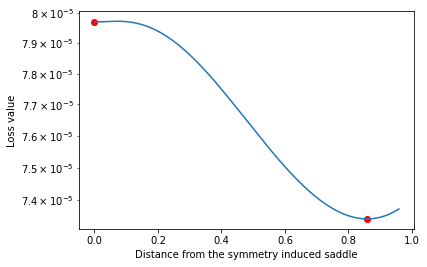

In [117]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
print(min(losses_to_min))

plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')

# Compute loss across the 1D line for a range of \mu

[-5.8908347581809227e-05  1.4352525937161062e-09]
[-5.9369729687770304e-05  1.3228171838800805e-09]
[-5.9784856014647839e-05  1.2232327768648017e-09]
[-6.0159593592624149e-05  1.1345950552816056e-09]
[-6.0498925276281147e-05  1.0553423799839865e-09]
[-6.0807101901736055e-05  9.8418375510781956e-10]
[-6.108776535647456e-05  9.200447424755085e-10]
[-6.134404861386429e-05  8.620251895285041e-10]
[-6.157865743711978e-05  8.093647893264317e-10]
[-6.179393742223365e-05  7.614193733387090e-10]


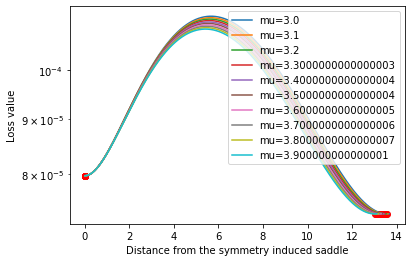

In [118]:
# mu_range = [0, 0.25, 0.5, 0.75, 1, 2, 5, 10]
mu_range = np.arange(3, 4, 0.1)
# mu_range = [-2.2, -2.1, -1.9, -1.8, -1.7, -1.6, -1.5]
# fig_escape, axs = plt.subplots(len(mu_range), 1)
# fig_escape.set_size_inches(5, 30)

for idx, mu in enumerate(mu_range):
    si_saddle = construct_si_saddle(final_weights, mu)
    directional_vector = local_min - si_saddle
    distances_to_saddle, losses_to_min = get_losses_across_line(si_saddle, directional_vector)
    plt.plot(distances_to_saddle, losses_to_min, label="mu=" + str(mu))
    
    # Mark the position of the closest saddle in the chart.
    plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
    plt.yscale('log')

    # Mark the position of the local min in the chart.
    local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - si_saddle)))
    plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')
    plt.xlabel('Distance from the symmetry induced saddle')
    plt.ylabel('Loss value')
    
    H = hessian(loss)(si_saddle)
    H = (H + H.T) / 2
    evals, _ = jnp.linalg.eigh(H)
    print(evals[:2])

plt.legend(loc="upper right")

# Compute the 2D plane between the SI saddles line and the local min

In [119]:
left_saddle_limit = deepcopy(closest_saddle)
right_saddle_limit = deepcopy(closest_saddle)
print('loss at left saddle limit:', loss_from_flattened_neuron_point(left_saddle_limit))
print('loss at right saddle limit:', loss_from_flattened_neuron_point(right_saddle_limit))
print('loss at closest saddle:', loss_from_flattened_neuron_point(closest_saddle))
print('loss at local min:', loss_from_flattened_neuron_point(local_min))

saddle_line_size = 10
left_saddle_limit[2 * H_student + idx_neuron1] += -saddle_line_size / 2
left_saddle_limit[2 * H_student + idx_neuron2] += saddle_line_size / 2

right_saddle_limit[2 * H_student + idx_neuron1] += saddle_line_size / 2
right_saddle_limit[2 * H_student + idx_neuron2] += -saddle_line_size / 2

loss at left saddle limit: 7.969688343304322e-05
loss at right saddle limit: 7.969688343304322e-05
loss at closest saddle: 7.969688343304322e-05
loss at local min: 7.340985286608199e-05


In [120]:
x_dist = np.linalg.norm(right_saddle_limit - left_saddle_limit)
y_dist = np.linalg.norm(closest_saddle - local_min)

direction_x_axis = (right_saddle_limit - left_saddle_limit) / np.linalg.norm(right_saddle_limit - left_saddle_limit)
direction_y_axis = (local_min - closest_saddle) / np.linalg.norm(local_min - closest_saddle)

num_steps_x_axis = 300
step_x_axis = x_dist / num_steps_x_axis
offset_oy = 70
num_steps_y_axis = 300 - 2 * offset_oy
step_y_axis = y_dist / num_steps_y_axis

left_saddle_limit = left_saddle_limit - offset_oy * step_y_axis * direction_y_axis
right_saddle_limit = right_saddle_limit - offset_oy * step_y_axis * direction_y_axis

y_dist = np.linalg.norm(closest_saddle - offset_oy * step_y_axis * direction_y_axis - \
                        local_min - offset_oy * step_y_axis * direction_y_axis)
num_steps_y_axis = 300

x_axis_points = []
y_axis_points= []

for num_step in range(num_steps_x_axis + 1):
  x_axis_points.append(num_step * step_x_axis * direction_x_axis)

for num_step in range(num_steps_y_axis + 1):
  y_axis_points.append(num_step * step_y_axis * direction_y_axis)


print(len(x_axis_points))

loss_values = []
neuron_points = [left_saddle_limit + x_axis_point + y_axis_point for y_axis_point in y_axis_points for x_axis_point in x_axis_points]

for y_axis_point in y_axis_points:
  for x_axis_point in x_axis_points:
    neuron_point = left_saddle_limit + x_axis_point + y_axis_point
    loss_val = loss_from_flattened_neuron_point(neuron_point)

    loss_values.append(np.log(loss_val))

301


In [121]:
def find_projection_on_plane(neuron_point, plane_neuron_points):
  min_dist = np.inf
  row_idx = None
  col_idx = None

  for idx, plane_neuron_point in enumerate(plane_neuron_points):
    if np.linalg.norm(neuron_point - plane_neuron_point) < min_dist:
      min_dist = np.linalg.norm(neuron_point - plane_neuron_point)
      row_idx = int(idx / (num_steps_x_axis + 1))
      col_idx = idx % (num_steps_x_axis + 1)
  
  return row_idx, col_idx

def fetch_trajectories_as_neuron_points(data_row):
  traj_neuron_points = []

  for i in range(0, int(data_row['student size'])):
    neuron_traj_x = np.fromstring(data_row['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_row['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    if len(traj_neuron_points) == 0:
      for j in range(0, len(neuron_traj_x)):
        traj_neuron_points.append([])

    for idx, _ in enumerate(neuron_traj_x):
      traj_neuron_points[idx].append(neuron_traj_x[idx])
      traj_neuron_points[idx].append(neuron_traj_y[idx])

  for i in range(0, int(data_row['student size'])):
    neuron_a = np.fromstring(data_row['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    for idx, _ in enumerate(neuron_a):
      traj_neuron_points[idx].append(neuron_a[idx])
    
  return traj_neuron_points

def plot_projected_trajectories(data_row):
  traj_neuron_points = fetch_trajectories_as_neuron_points(data_row)

  projected_points_row = []
  projected_points_col = []
  # Necessarily include the first point.
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[0], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)

  for idx, traj_neuron_point in enumerate(traj_neuron_points):
    if idx >= len(traj_neuron_points) - 2:
      break
    if idx % 5 == 0:
      row_idx, col_idx = find_projection_on_plane(traj_neuron_point, neuron_points)
      projected_points_row.append(row_idx)
      projected_points_col.append(col_idx)

  # Include the second to last point (Adam last point).
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[-2], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)
  plt.scatter([col_idx], [row_idx], marker='+', color='red')
  print(row_idx, col_idx)


  # Necessarily include the last point.
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[-1], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)
  print(row_idx, col_idx)

  plt.plot(projected_points_col, projected_points_row, color='red')
  plt.scatter(projected_points_col[0], projected_points_row[0],
              marker='*', color='red')
  plt.scatter(projected_points_col[-1], projected_points_row[-1],
              marker='*', color='red')

239 300
230 150


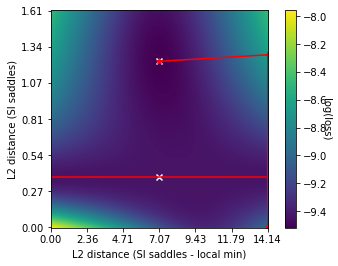

In [122]:
closest_saddle_ox_coord = int (num_steps_x_axis / 2)
closest_saddle_oy_coord = offset_oy

local_min_ox_coord = closest_saddle_ox_coord
local_min_oy_coord = num_steps_y_axis - offset_oy

np_loss_values = np.array(loss_values).reshape(num_steps_y_axis + 1,
                                               num_steps_x_axis + 1)

fig_2dplane, ax = plt.subplots(1, 1)

ticks_oy = np.linspace(0, num_steps_y_axis, 7)
ticks_ox = np.linspace(0, num_steps_x_axis, 7)

ticklabels_ox = ["{:.2f}".format(np.linalg.norm(neuron_points[int(i)] - neuron_points[0])) for i in ticks_ox]
ticklabels_oy = ["{:.2f}".format(np.linalg.norm(neuron_points[(num_steps_x_axis + 1) * int(i)] - neuron_points[0])) for i in ticks_oy]

grid_img = ax.imshow(np_loss_values, interpolation='bilinear', origin = 'lower')
ax.set_xticks(ticks_ox)
ax.set_xticklabels(ticklabels_ox)
ax.set_yticks(ticks_oy)
ax.set_yticklabels(ticklabels_oy)

ax.scatter([closest_saddle_ox_coord, local_min_ox_coord],
           [closest_saddle_oy_coord, local_min_oy_coord],
           marker='x', color='white')

ax.plot([0, num_steps_x_axis],
        [closest_saddle_oy_coord, closest_saddle_oy_coord], color='red')


fig_2dplane.colorbar(grid_img).set_label('log(loss)',rotation=270)
# fig_2dplane.suptitle('Loss(log) on the plane formed by local min the SI saddles')

plot_projected_trajectories(sample_point)
plt.xlabel('L2 distance (SI saddles - local min)')
plt.ylabel('L2 distance (SI saddles)')

plt.show()

Text(0, 0.5, 'L2 norm between 2 neurons')

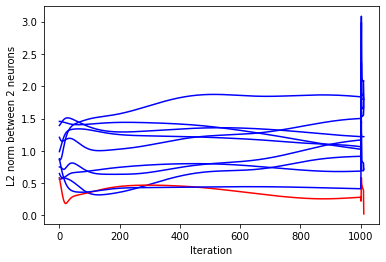

In [123]:
traj_neuron_points = fetch_trajectories_as_neuron_points(sample_point)
traj_neuron_points = np.array(traj_neuron_points)
for i in range(H_student):
    for j in range(i + 1, H_student):
        traj_neuron_i = traj_neuron_points[:, 2 * i : 2 * i + 2]

        traj_neuron_j = traj_neuron_points[:, 2 * j : 2 * j + 2]
        
        inter_neuron_distances = np.sqrt(((traj_neuron_i - traj_neuron_j) ** 2).sum(axis=-1))
        color = 'blue'
        if i == idx_neuron1 and j == idx_neuron2:
            color = 'red'
        plt.plot(np.arange(0, len(inter_neuron_distances)), inter_neuron_distances, color=color)

plt.xlabel('Iteration')
plt.ylabel('L2 norm between 2 neurons')

# Finding the SI saddle directly from the local min

## Using second order optimization

In [469]:
def regularized_loss(w):
  network_size = int(len(w) / 3)
  w_in = w[0 : 2 * network_size].reshape(network_size, D_in)
  w_out = w[2 * network_size : ].reshape(network_size)
  # print(w_out)

  # Don't add the outgoing weights for now.
  neuron_1 = jnp.append(w_in[idx_neuron1, :], w_out[idx_neuron1])
  neuron_2 = jnp.append(w_in[idx_neuron2, :], w_out[idx_neuron2])
  # neuron_1 = w_in[idx_neuron1, :]
  # neuron_2 = w_in[idx_neuron2, :]

  preds = jnp.transpose(predict(w_in, w_out))
  return jnp.mean(jnp.square(preds - jnp_labels)) + \
         2 * jnp.linalg.norm(w_in[idx_neuron1, :] - w_in[idx_neuron2, :]) + \
         2 * jnp.linalg.norm(w_out[idx_neuron1] - w_out[idx_neuron2])


In [470]:
def regularized_loss_obj(weights, grad):
  loss_val = regularized_loss(jnp.array(weights))
  if grad.size > 0:
    grad[:] = np.array(jax_grad(regularized_loss)(jnp.array(weights)), dtype=np.float64)
  return np.float64(loss_val)

In [471]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
w_out = np.array([outgoing_weights], dtype=np.float64)
weights = np.append(w_in.reshape(H_student * 2),
                    w_out.reshape(H_student))

In [472]:
def regularized_second_order_train(weights):
    lower_bound = weights - 15
    upper_bound = weights + 15
    opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
    opt.set_lower_bounds(lower_bound)
    opt.set_upper_bounds(upper_bound)
    opt.set_min_objective(regularized_loss_obj)
    opt.set_maxtime(100)
    opt.set_xtol_rel(1e-10)
    opt.set_initial_step(1e-32)
    final_weights = opt.optimize(weights)
    return final_weights

In [473]:
final_weights = regularized_second_order_train(weights)
print('Gradient at this point:', jnp.linalg.norm(jax_grad(loss)(final_weights)))
w_in_torch_format = final_weights[0 : 2 * H_student].reshape(H_student, 2)
w_out_torch_format = final_weights[2 * H_student : ].reshape(H_student)

Gradient at this point: 0.4920517310812006


Text(0, 0.5, 'w2')

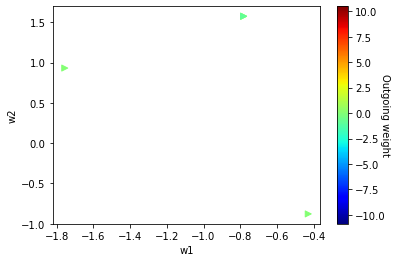

In [474]:
plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format,
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

In [382]:
def find_saddle_line_from_reg_saddle(final_weights):
    saddle_smallest_u = deepcopy(final_weights)
    saddle_smallest_u[2 * H_student + idx_neuron1] -= 1
    saddle_smallest_u[2 * H_student + idx_neuron2] += 1

    saddle_largest_u = deepcopy(final_weights)

    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, directional_vector

In [383]:
closest_saddle, directional_vector = find_saddle_line_from_reg_saddle(final_weights)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Distance to local min: 2.9759376479514335


In [384]:
line_point = closest_saddle
distances_to_saddle = [0]
losses_to_min = [loss(closest_saddle)]

print(loss(line_point))

while True:
  eps = 1e-4
  line_point = line_point + eps * directional_vector

  loss_val = loss(line_point)
  distances_to_saddle.append(np.linalg.norm(closest_saddle - line_point))
  losses_to_min.append(loss_val)

  if np.linalg.norm(line_point - closest_saddle) >= 1 + np.linalg.norm(local_min - closest_saddle):
    break

0.1291476554225628


0.14583887834588194


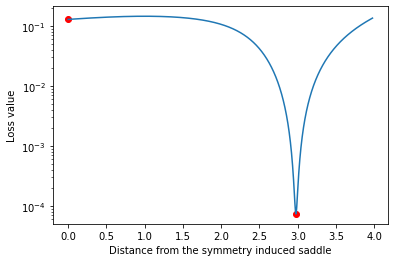

In [385]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')

## Using first order optimization

In [262]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
w_out = np.array([outgoing_weights], dtype=np.float64)
weights = np.append(w_in.reshape(H_student * 2),
                    w_out.reshape(H_student))

In [263]:
def pytorch_regularized_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

def regularized_first_order_train(model, x, y_labels,  N = 10, Ninner = 10 ** 3, Nstart = 10):
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
  psi = 2

  loss_vals = []

  for i in range(1, N + 1):
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)

      model_params = []
      for param in model.parameters():
        model_params.append(param)
      model_params_w_in = model_params[0]
      model_params_w_out = model_params[1]
      
      neuron1 = torch.cat((model_params_w_in[idx_neuron1, :], model_params_w_out[:, idx_neuron1]), dim=-1)
      neuron2 = torch.cat((model_params_w_in[idx_neuron2, :], model_params_w_out[:, idx_neuron2]), dim=-1)
      # print(neuron1, neuron2)
      
      loss = pytorch_regularized_loss(y, y_labels) + psi * torch.norm(neuron1 - neuron2)

      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart  : j]))

    loss_vals.append(np.mean(loss_tmp))

    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    
#   final_weights = train_second_order(model)
#   final_weights = regularized_second_order_train(jnp.append(
#                       deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
#                       deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student))))
#   return final_weights
  return np.append(deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
                     deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student)))


In [264]:
dummy_model = DummyNetwork(D_in, H_student, D_out, torch.DoubleTensor(w_in), torch.DoubleTensor(w_out))

In [265]:
final_weights = regularized_first_order_train(dummy_model, dataset, y_labels)

Iteration: 1000, loss: 38.73310721521072, gradient norm: tensor(2.8284)
Iteration: 2000, loss: 30.733161883833027, gradient norm: tensor(2.8284)
Iteration: 3000, loss: 22.733267369540183, gradient norm: tensor(2.8284)
Iteration: 4000, loss: 14.733457433751457, gradient norm: tensor(2.8284)
Iteration: 5000, loss: 6.7337504673463595, gradient norm: tensor(2.8284)
Iteration: 6000, loss: 0.4700141460268657, gradient norm: tensor(2.8284)
Iteration: 7000, loss: 0.0043226382295720785, gradient norm: tensor(2.8284)
Iteration: 8000, loss: 0.004305552815168125, gradient norm: tensor(2.8284)
Iteration: 9000, loss: 0.004292082598696657, gradient norm: tensor(2.8284)
Iteration: 10000, loss: 0.004280356323754035, gradient norm: tensor(2.8284)


In [266]:
print(final_weights)
print('Gradient at this point:', jnp.linalg.norm(jax_grad(loss)(final_weights)))
w_in_torch_format = final_weights[0 : 2 * H_student].reshape(H_student, 2)
w_out_torch_format = final_weights[2 * H_student : ].reshape(H_student)

[-1.2823087629281762    1.0368687988127223   -0.7322801632363609
  1.4863521358830447   -0.9053195532362283   -0.5831255552975126
 -1.2823855915739941    1.036836288845331     0.18618102615082885
 -0.06357192687393524  -0.17894735280678553   0.060380862434177444
 -0.46350947458961766  -0.1821409280651973    0.7655888281637966  ]
Gradient at this point: 0.0032355010352734617


Text(0, 0.5, 'w2')

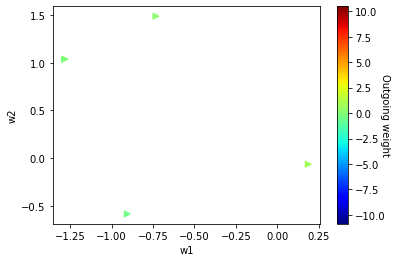

In [267]:
plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format,
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

In [268]:
closest_saddle, directional_vector = find_saddle_line_from_reg_saddle(final_weights)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Distance to local min: 0.03638388679587352


In [269]:
line_point = closest_saddle
distances_to_saddle = [0]
losses_to_min = [loss(closest_saddle)]

print(loss(line_point))

while True:
  eps = 1e-4
  line_point = line_point + eps * directional_vector

  loss_val = loss(line_point)
  distances_to_saddle.append(np.linalg.norm(closest_saddle - line_point))
  losses_to_min.append(loss_val)

  if np.linalg.norm(line_point - closest_saddle) >= 0.01 + np.linalg.norm(local_min - closest_saddle):
    break

0.0002726102525129159


0.0002726102525129159


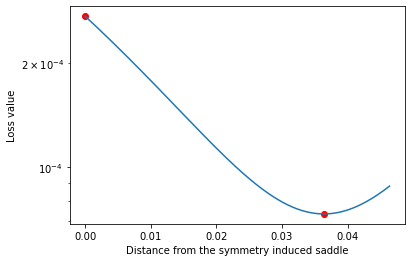

In [271]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')